In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

In [2]:
#設定路徑
path="theSimpsons-train/train"
data_dir = pathlib.Path(path)

In [3]:
#觀察圖片數量
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

96929


In [4]:
#Data Augmentation
#建立ImageDataGenerator
datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    validation_split=0.2
)

In [5]:
#設定圖片大小與batch大小
batch_size = 32
img_height = 180
img_width = 180
#使用flow_from_directory讀取資料集
train_ds = datagen.flow_from_directory(
  data_dir,
  subset="training",
  seed=123, #設定隨機取樣
  target_size=(img_height, img_width),
  batch_size=batch_size)

Found 77560 images belonging to 50 classes.


In [6]:
val_ds = datagen.flow_from_directory(
  data_dir,
  subset="validation",
  seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size)

Found 19369 images belonging to 50 classes.


In [7]:
#Label_class
class_names = train_ds.class_indices
print(class_names)

{'abraham_grampa_simpson': 0, 'agnes_skinner': 1, 'apu_nahasapeemapetilon': 2, 'barney_gumble': 3, 'bart_simpson': 4, 'brandine_spuckler': 5, 'carl_carlson': 6, 'charles_montgomery_burns': 7, 'chief_wiggum': 8, 'cletus_spuckler': 9, 'comic_book_guy': 10, 'disco_stu': 11, 'dolph_starbeam': 12, 'duff_man': 13, 'edna_krabappel': 14, 'fat_tony': 15, 'gary_chalmers': 16, 'gil': 17, 'groundskeeper_willie': 18, 'homer_simpson': 19, 'jimbo_jones': 20, 'kearney_zzyzwicz': 21, 'kent_brockman': 22, 'krusty_the_clown': 23, 'lenny_leonard': 24, 'lionel_hutz': 25, 'lisa_simpson': 26, 'lunchlady_doris': 27, 'maggie_simpson': 28, 'marge_simpson': 29, 'martin_prince': 30, 'mayor_quimby': 31, 'milhouse_van_houten': 32, 'miss_hoover': 33, 'moe_szyslak': 34, 'ned_flanders': 35, 'nelson_muntz': 36, 'otto_mann': 37, 'patty_bouvier': 38, 'principal_skinner': 39, 'professor_john_frink': 40, 'rainier_wolfcastle': 41, 'ralph_wiggum': 42, 'selma_bouvier': 43, 'sideshow_bob': 44, 'sideshow_mel': 45, 'snake_jailbi

In [8]:
#轉成list
class_list=[key for key in class_names.keys()]
class_list

['abraham_grampa_simpson',
 'agnes_skinner',
 'apu_nahasapeemapetilon',
 'barney_gumble',
 'bart_simpson',
 'brandine_spuckler',
 'carl_carlson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'cletus_spuckler',
 'comic_book_guy',
 'disco_stu',
 'dolph_starbeam',
 'duff_man',
 'edna_krabappel',
 'fat_tony',
 'gary_chalmers',
 'gil',
 'groundskeeper_willie',
 'homer_simpson',
 'jimbo_jones',
 'kearney_zzyzwicz',
 'kent_brockman',
 'krusty_the_clown',
 'lenny_leonard',
 'lionel_hutz',
 'lisa_simpson',
 'lunchlady_doris',
 'maggie_simpson',
 'marge_simpson',
 'martin_prince',
 'mayor_quimby',
 'milhouse_van_houten',
 'miss_hoover',
 'moe_szyslak',
 'ned_flanders',
 'nelson_muntz',
 'otto_mann',
 'patty_bouvier',
 'principal_skinner',
 'professor_john_frink',
 'rainier_wolfcastle',
 'ralph_wiggum',
 'selma_bouvier',
 'sideshow_bob',
 'sideshow_mel',
 'snake_jailbird',
 'timothy_lovejoy',
 'troy_mcclure',
 'waylon_smithers']

In [9]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate,Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50


In [10]:
num_classes = 50

def model_ResNet50():
#載入預訓練模型_ResNet50
    base_model = ResNet50(weights='imagenet', #載入權重
                          include_top=False, #將最後輸出層移除
                          pooling=max, #設定為maxpooling
                          input_shape=(img_height,img_width,3))

    #transfer learning
    #只訓練最後輸出層，預訓練模型不做訓練，當作特徵提取器。
    #但此次資料集夠大，將不採用此方式。
    #for layer in base_model.layers: 
        #layer.trainable = False

    add_model = Sequential()
    add_model.add(base_model)
    add_model.add(GlobalAveragePooling2D()) #縮小輸入的維度
    #加入兩層，並使用L2正規化
    add_model.add(Dense(1024, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
    add_model.add(Dense(512, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
    #最後以softmax作為輸出分類。
    add_model.add(Dense(num_classes, activation='softmax')) #num_classes=50種

    model = add_model
    
    #設定optimizer與lossFunction
    optimizer='adam' 
    model.compile(
      optimizer=optimizer,
      loss=tf.losses.CategoricalCrossentropy(),
      metrics=['accuracy'])

    model.summary()
    return model


In [11]:
model=model_ResNet50()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 6, 6, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                25650     
Total params: 26,236,338
Trainable params: 26,183,218
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
# 創建模型儲存目錄：
model_dir = 'lab-logs/models/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
# TensorBoard回調函數會幫忙紀錄訓練資訊，並存成TensorBoard的紀錄檔
log_dir = os.path.join('lab-logs', 'model-7')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# ModelCheckpoint回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min則代表監測數據越小越好。
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-7.h5',monitor='val_accuracy',save_best_only=True,mode='max')



In [13]:
#載入訓練好的模型 
#model = tf.keras.models.load_model('lab-logs/models/Best-model-2.h5')

In [14]:
#開始訓練
history = model.fit(train_ds,
          callbacks=[model_mckp],
          epochs=20,
          validation_data=val_ds)
          

Epoch 1/20
2424/2424 [==============================] - 2074s 852ms/step - loss: 1.9701 - accuracy: 0.5478 - val_loss: 1.2189 - val_accuracy: 0.7216


C:\Users\D\anaconda3\envs\ml\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
2424/2424 [==============================] - 1573s 649ms/step - loss: 0.7413 - accuracy: 0.8430 - val_loss: 0.9380 - val_accuracy: 0.7948
Epoch 3/20
2424/2424 [==============================] - 1576s 650ms/step - loss: 0.5244 - accuracy: 0.8931 - val_loss: 1.0251 - val_accuracy: 0.7728
Epoch 4/20
2424/2424 [==============================] - 1557s 642ms/step - loss: 0.4108 - accuracy: 0.9186 - val_loss: 0.7677 - val_accuracy: 0.8316
Epoch 5/20
2424/2424 [==============================] - 1554s 641ms/step - loss: 0.3422 - accuracy: 0.9331 - val_loss: 0.4443 - val_accuracy: 0.9062
Epoch 6/20
2424/2424 [==============================] - 1557s 642ms/step - loss: 0.2865 - accuracy: 0.9450 - val_loss: 0.6739 - val_accuracy: 0.8560
Epoch 7/20
2424/2424 [==============================] - 1552s 640ms/step - loss: 0.2549 - accuracy: 0.9516 - val_loss: 0.5829 - val_accuracy: 0.8689
Epoch 8/20
2424/2424 [==============================] - 1549s 639ms/step - loss: 0.2236 - accuracy: 0.9576

In [15]:
history.history.keys() # 查看history儲存的資訊有哪些

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

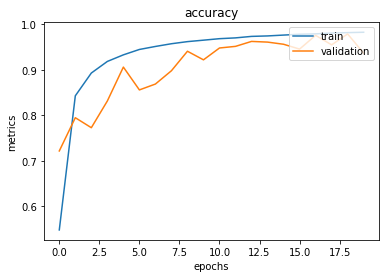

In [16]:
from matplotlib import pyplot as plt
#Mean absolute error
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('accuracy')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

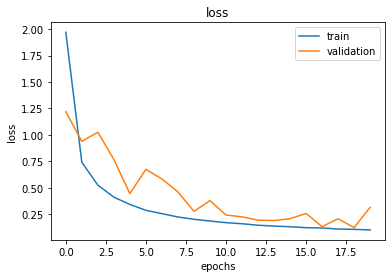

In [17]:
#Mean square error
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')